# Pangeo Exploration Part II:
## Exploratory Data Analysis of Iberian Peninsula Subset

### NOTE!
**Do not run this Notebook, as I haven't included the very large data files which it uses. Refer to it as a static notebook**

In [1]:
import xarray as xr
import dask as da
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
from cartopy import crs as ccrs, feature as cfeature
%matplotlib inline

### Loading the Data and Setup

In [2]:
da.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
iberian = xr.open_dataset('iberian.nc', engine='netcdf4', chunks={'time':10})

##### Set some variables for convenient test indexing

In [4]:
date = '2017-12-02'
#latitude = iberian.rlat[50]
#longitude = iberian.rlon[50]
latitude = iberian.rlat.sel(rlat=-8, method='nearest')
longitude = iberian.rlon.sel(rlon=-16, method='nearest')
level = 5.0
levels = [10.0, 5.0, 4.0, 3.0, 2.0, 1.0]

#### Summary Statistics Of All Variables

##### Converting to Pandas.dataframe to Use .describe

In [5]:
iberian_df = iberian.to_dataframe()
iberian_df.describe()

rotated_pole      pressure    saturation   water_table          mask
count    84315000.0  8.431500e+07  8.431500e+07  3.420050e+06  8.431500e+07
mean            1.0 -1.332404e+38  5.452532e-01  8.194114e+00  6.084416e-01
std             0.0  1.660914e+38  3.535087e-01  1.323468e+01  4.880988e-01
min             1.0 -3.402823e+38  1.007862e-01 -4.534462e+00  0.000000e+00
25%             1.0 -3.402823e+38  2.000000e-01 -5.652642e-02  0.000000e+00
50%             1.0 -2.532675e+00  4.205692e-01  1.628303e+00  1.000000e+00
75%             1.0  4.740383e-01  1.000000e+00  1.162484e+01  1.000000e+00
max             1.0  5.403446e+01  1.000000e+00  5.035423e+01  1.000000e+00

<hr>

### Creating the Rotated Pole CRS

In [6]:
iberian_rotated_pole = ccrs.RotatedPole(
    iberian.rotated_pole.grid_north_pole_longitude, 
    iberian.rotated_pole.grid_north_pole_latitude,)

In [7]:
iberian_rotated_pole

### Correlations

In [8]:
xr.corr(iberian.pressure, iberian.saturation).compute()

<xarray.DataArray ()>
array(0.78459807)

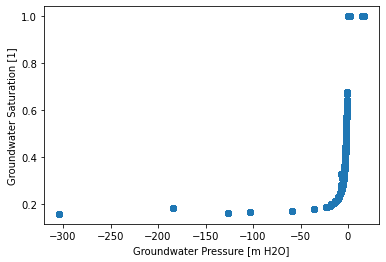

In [9]:
iberian.sel(rlat=latitude, rlon=longitude) \
    .where((iberian.mask == 1) & (iberian.pressure > -5)) \
    .plot.scatter(x='pressure', y='saturation')

### Maps: Lat / Lon / Variable

##### All Variables, No Projection

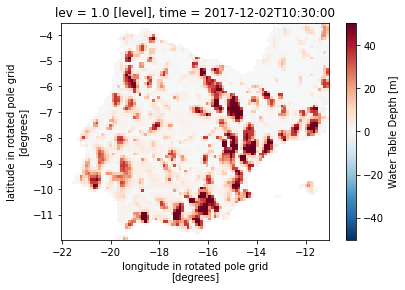

In [10]:
iberian.water_table.sel(time=date, lev=1.0).where(iberian.mask == 1).plot()

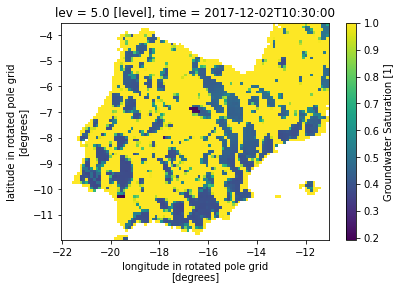

In [11]:
iberian.saturation.sel(time=date, lev=level).where(iberian.mask == 1).plot()

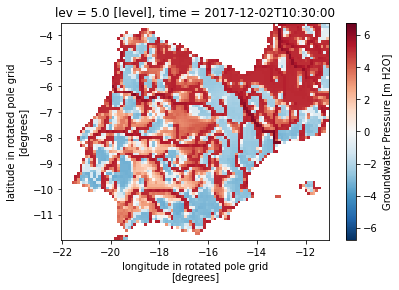

In [12]:
iberian.pressure.sel(time=date, lev=level).where(iberian.mask == 1).plot()

##### Water Table Depth, Explore Color Bar Options, Orthographic Projection

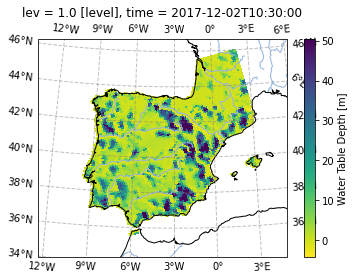

In [13]:
# Get color bar min and max
range_min = iberian.water_table.sel(time=date, lev=1.0).where(iberian.mask == 1).min()
range_max = iberian.water_table.sel(time=date, lev=1.0).where(iberian.mask == 1).max()

# Defined plot
fig = iberian.water_table \
    .sel(time=date, lev=1.0) \
    .where(iberian.mask == 1) \
    .plot(subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41),  
        facecolor="white"),
        transform=iberian_rotated_pole,
         cmap='viridis_r', vmin=range_min.values, vmax=range_max.values)

fig.axes.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
#fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

In [14]:
no_negative_table = iberian.water_table.where(iberian.water_table >= 0, drop=True)

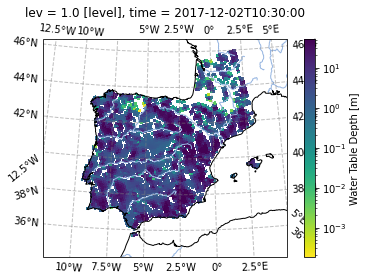

In [15]:
# Get color bar min and max
range_min = no_negative_table.sel(time=date, lev=1.0).where(iberian.mask == 1).min()
range_max = no_negative_table.sel(time=date, lev=1.0).where(iberian.mask == 1).max()

# Defined plot
fig = no_negative_table \
    .sel(time=date, lev=1.0) \
    .where(iberian.mask == 1) \
    .plot(subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41),  
        facecolor="white"),
        transform=iberian_rotated_pole,
                  norm=colors.LogNorm(),
        cmap='viridis_r', vmin=range_min.values, vmax=range_max.values)

fig.axes.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
#fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

##### Water Table, Logarithmic Color Map

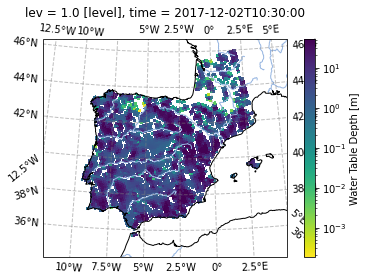

In [16]:
# Get color bar min and max
range_min = no_negative_table.sel(time=date, lev=1.0).where(iberian.mask == 1).min()
range_max = no_negative_table.sel(time=date, lev=1.0).where(iberian.mask == 1).max()

# Defined plot
fig = no_negative_table \
    .sel(time=date, lev=1.0) \
    .where(iberian.mask == 1) \
    .plot(subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41),  
        facecolor="white"),
        transform=iberian_rotated_pole,
        norm=colors.LogNorm(vmin=range_min.values, vmax=range_max.values), #normalizes to logarithmic scale
        cmap='viridis_r')

fig.axes.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
#fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

##### Maps of All Variables for Presentation

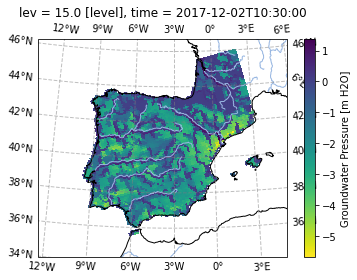

In [17]:
level = 15.0
# Get color bar min and max
range_min = iberian.pressure.sel(time=date, lev=level).where(iberian.mask == 1).min().values
range_max = iberian.pressure.sel(time=date, lev=level).where(iberian.mask == 1).max().values

# Defined plot
fig = iberian.pressure \
    .sel(time=date, lev=level) \
    .where(iberian.mask == 1) \
    .plot(subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41)),
        transform=iberian_rotated_pole,
        cmap='viridis_r', vmin=range_min, vmax=range_max)

fig.axes.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

##### Pressure, Faceted on Levels, Orthographic Projection

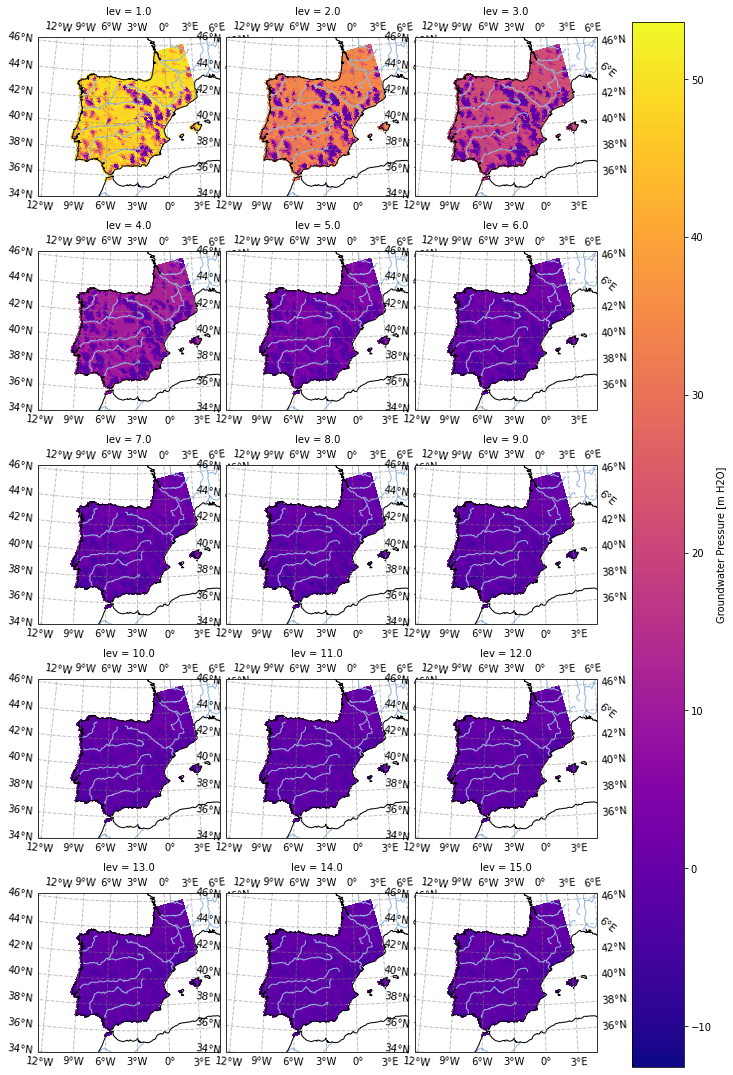

In [18]:
# Get color bar min and max
range_min = iberian.pressure.sel(time=date).where(iberian.mask == 1).min()
range_max = iberian.pressure.sel(time=date).where(iberian.mask == 1).max()

# Defined plot
fig = iberian.pressure \
    .sel(time=date) \
    .where(iberian.mask == 1) \
    .plot(x="rlon", y="rlat", col="lev", col_wrap=3,
        subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41),  
        facecolor="white"),
        transform=iberian_rotated_pole,
         cmap='plasma', vmin=range_min.values, vmax=range_max.values)

# Loop through each axes in the facet
for ax in fig.axes.flat:
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.add_feature(cfeature.RIVERS)
    ax.coastlines()

### Exploring Different Projections With Cartopy (Saturation Maps)

##### Orthographic Projection

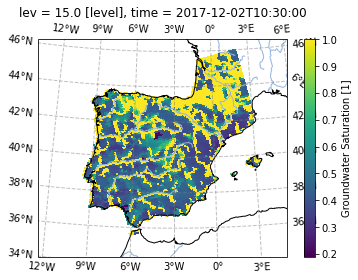

In [19]:
fig = iberian.saturation.sel(time=date, lev=level).where(iberian.mask == 1).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41),
        facecolor="white"),
    transform=iberian_rotated_pole,
    )
fig.axes.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
#fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

##### PlateCarree Projection

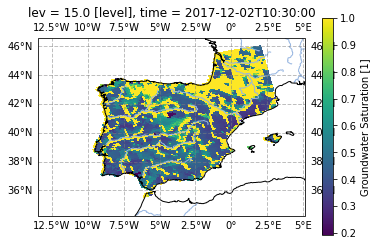

In [20]:
fig = iberian.saturation.sel(time=date, lev=level).where(iberian.mask == 1).plot(
    subplot_kws=dict(projection=ccrs.PlateCarree(),
        #central_longitude=-3, central_latitude=41), 
        facecolor="white"),
    transform=iberian_rotated_pole,
    )
fig.axes.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
#fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

##### Lambert Azimuthal Equal Area Projection

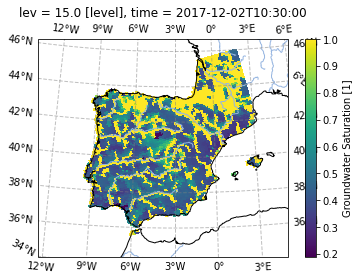

In [21]:
fig = iberian.saturation.sel(time=date, lev=level).where(iberian.mask == 1).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(
        central_longitude=-3, central_latitude=41), 
        facecolor="white"),
    transform=iberian_rotated_pole,
    )
fig.axes.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
#fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

##### Lambert Conformal Projection

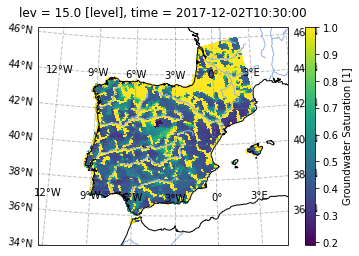

In [22]:
fig = iberian.saturation.sel(time=date, lev=level).where(iberian.mask == 1).plot(
    subplot_kws=dict(projection=ccrs.LambertConformal(
        central_longitude=-3, central_latitude=41), 
        facecolor="white"),
    transform=iberian_rotated_pole,
    )
fig.axes.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
#fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

### Faceting: Multiple Plots for Series of data in 4D

##### Saturation, Fixed Time, Plot Each Level, No Projection

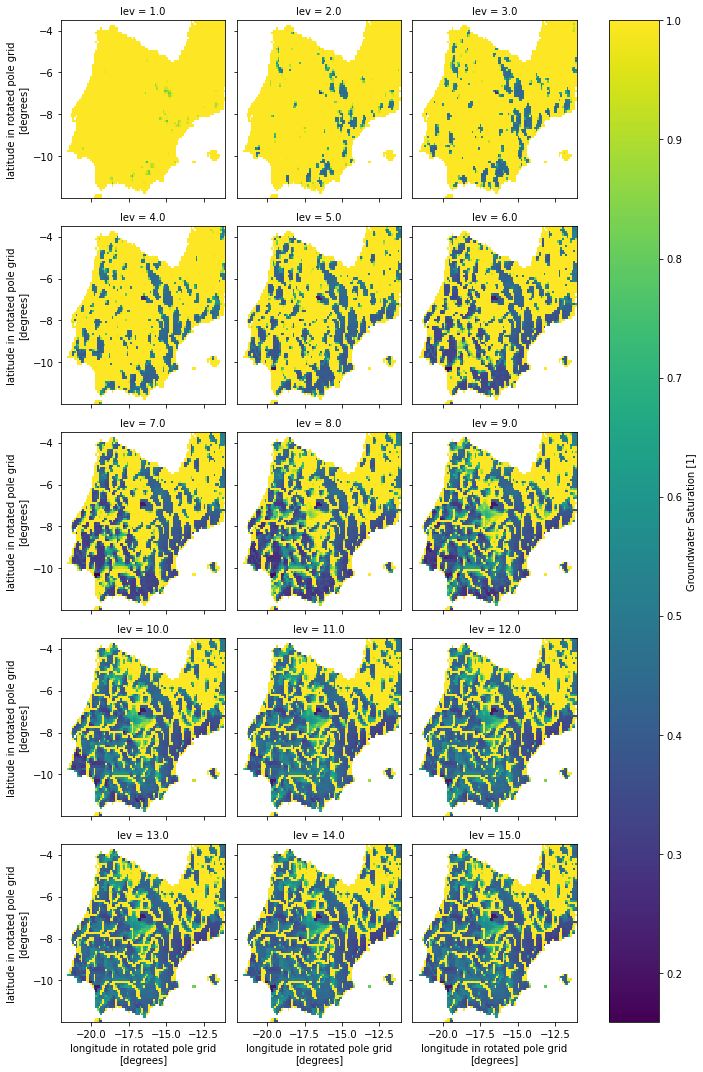

In [23]:
iberian.saturation \
    .sel(time=date) \
    .where(iberian.mask == 1) \
    .plot(x="rlon", y="rlat", col="lev", col_wrap=3)

##### Saturation, Fixed Time, Plot Each Level, Orthographic Projection

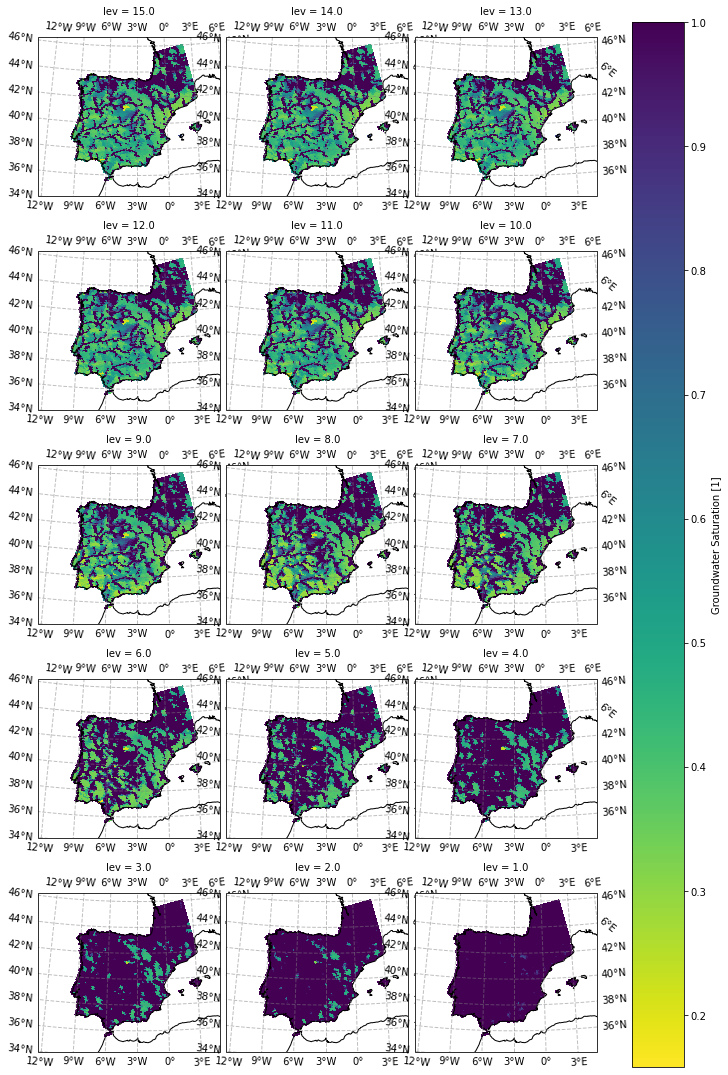

In [24]:
# Get color bar min and max
range_min = iberian.saturation.sel(time=date).where(iberian.mask == 1).min()
range_max = iberian.saturation.sel(time=date).where(iberian.mask == 1).max()

fig = iberian.saturation \
    .sel(time=date, lev=[15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0]) \
    .where(iberian.mask == 1) \
    .plot(x="rlon", y="rlat", col="lev", col_wrap=3,
        subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41)),
        transform=iberian_rotated_pole,
        cmap='viridis_r', vmin=range_min.values, vmax=range_max.values)

for ax in fig.axes.flat:
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    #ax.add_feature(cfeature.RIVERS)
    ax.coastlines()
    
#plt.savefig('figures/saturation-facet-all-levels.png', facecolor='white', bbox_inches='tight')

##### Saturation, Fixed Time, Plot 5 Deepest Levels and Middle Soil Level

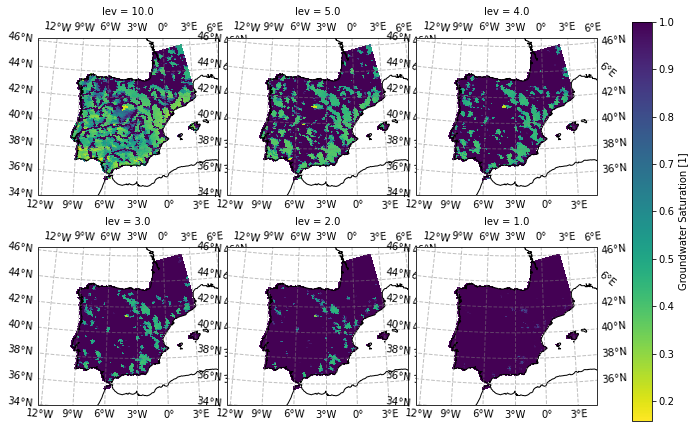

In [25]:
# Get color bar min and max
range_min = iberian.saturation.sel(time=date).where(iberian.mask == 1).min()
range_max = iberian.saturation.sel(time=date).where(iberian.mask == 1).max()

fig = iberian.saturation \
    .sel(time=date, lev=[10.0, 5.0, 4.0, 3.0, 2.0, 1.0]) \
    .where(iberian.mask == 1) \
    .plot(x="rlon", y="rlat", col="lev", col_wrap=3,
        subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41)),
        transform=iberian_rotated_pole,
        cmap='viridis_r', vmin=range_min.values, vmax=range_max.values)

for ax in fig.axes.flat:
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    #ax.add_feature(cfeature.RIVERS)
    ax.coastlines()
    
#plt.savefig('figures/saturation-facet-levels.png', facecolor='white', bbox_inches='tight')

##### Pressure, Fixed Time, Plot 5 Deepest Levels and Middle Soil Level

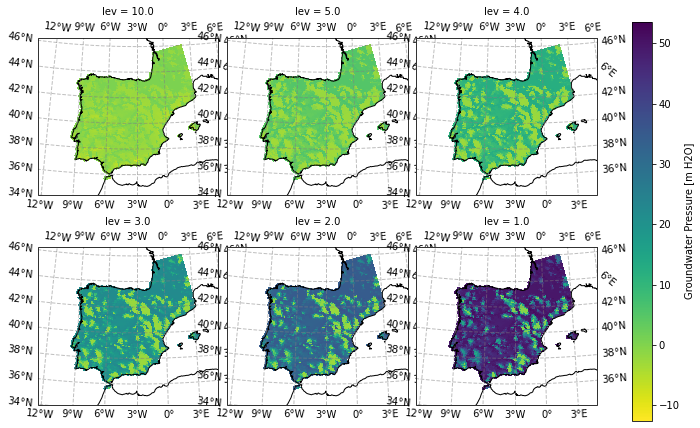

In [26]:
# Get color bar min and max
range_min = iberian.pressure.sel(time=date).where(iberian.mask == 1).min()
range_max = iberian.pressure.sel(time=date).where(iberian.mask == 1).max()

fig = iberian.pressure \
    .sel(time=date, lev=[10.0, 5.0, 4.0, 3.0, 2.0, 1.0]) \
    .where(iberian.mask == 1) \
    .plot(x="rlon", y="rlat", col="lev", col_wrap=3,
        subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41)),
        transform=iberian_rotated_pole,
        cmap='viridis_r', vmin=range_min.values, vmax=range_max.values)

for ax in fig.axes.flat:
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    #ax.add_feature(cfeature.RIVERS)
    ax.coastlines()
    
#plt.savefig('figures/pressure-facet-levels.png', facecolor='white', bbox_inches='tight')

### Groupby Functions with Water Table Seasons

In [27]:
water_table_by_season = no_negative_table.groupby('time.season').mean('time')
water_table_by_season

<xarray.DataArray 'water_table' (season: 4, lev: 1, rlat: 77, rlon: 96)>
dask.array<stack, shape=(4, 1, 77, 96), dtype=float64, chunksize=(1, 1, 77, 32), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 1.0
  * rlon     (rlon) float64 -21.55 -21.44 -21.33 -21.22 ... -11.32 -11.21 -11.1
  * rlat     (rlat) float64 -11.93 -11.82 -11.71 -11.6 ... -3.792 -3.682 -3.572
    mask     (rlat, rlon) float64 dask.array<chunksize=(77, 96), meta=np.ndarray>
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

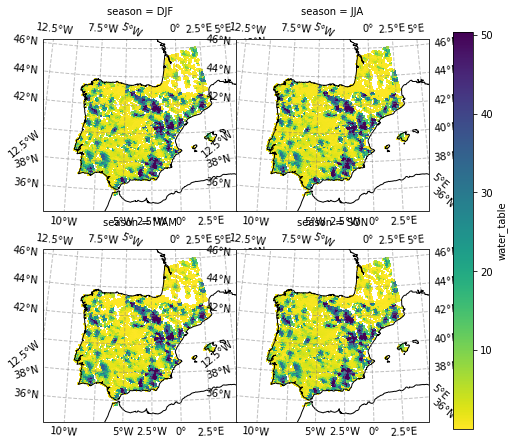

In [28]:
# Get color bar min and max
range_min = water_table_by_season.min().values
range_max = water_table_by_season.max().values

fig = water_table_by_season \
    .plot(x="rlon", y="rlat", col="season", col_wrap=2,
        subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41)),
        transform=iberian_rotated_pole,
        cmap='viridis_r', vmin=range_min, vmax=range_max)

for ax in fig.axes.flat:
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    #ax.add_feature(cfeature.RIVERS)
    ax.coastlines()
    
#plt.savefig('figures/table_season-facet-levels.png', facecolor='white', bbox_inches='tight')

In [29]:
winter_summer_delta = water_table_by_season.sel(season='DJF') - water_table_by_season.sel(season='JJA')

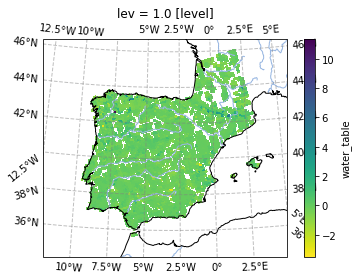

In [30]:
# Get color bar min and max
range_min = winter_summer_delta.min()
range_max = winter_summer_delta.max()

# Defined plot
fig = winter_summer_delta \
    .plot(subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41),  
        facecolor="white"),
        transform=iberian_rotated_pole,
        cmap='viridis_r', vmin=range_min.values, vmax=range_max.values)

fig.axes.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
#fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

#plt.savefig('figures/water-table-winter-summer-delta-with-outliers.png', facecolor='white', bbox_inches='tight')

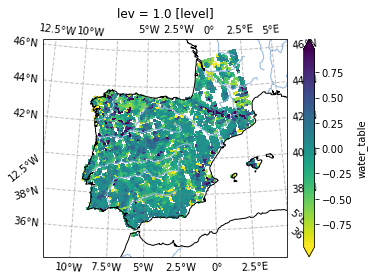

In [31]:
# Get color bar min and max
range_min = winter_summer_delta.min()
range_max = winter_summer_delta.max()

# Defined plot
fig = winter_summer_delta \
    .plot(subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41)),
        robust=True,
        transform=iberian_rotated_pole,
        cmap='viridis_r')

fig.axes.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
#fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

#plt.savefig('figures/water-table-winter-summer-delta-no-outliers.png', facecolor='white', bbox_inches='tight')

### Stripping Outliers (custom beyond robust method)

In [32]:
# Quantile operation requires the data array to be in one chunk.
winter_summer_delta = winter_summer_delta.chunk(dict(rlon=-1))

In [33]:
# Verifying quantile output (it is correct!)
winter_summer_delta.to_dataframe().describe()

mask  water_table
count  7392.000000  3451.000000
mean      0.633793    -0.040295
std       0.481800     0.489435
min       0.000000    -3.512498
25%       0.000000    -0.229393
50%       1.000000    -0.018120
75%       1.000000     0.088180
max       1.000000    11.310871

In [34]:
# Testing Quantile
winter_summer_delta.quantile(.01).values

array(-1.01689758)

In [35]:
def strip_outliers(data, lower_percentile, upper_percentile):
    
    # Quantile operation requires the data array to be in one chunk.
    data = data.chunk(dict(rlon=-1))
    
    # define upper and lower quantile boundary
    upper_limit = data.quantile(upper_percentile)
    lower_limit = data.quantile(lower_percentile)
    
    # create a mask within the upper and lower boundary
    filtered_data = data.where((data <= upper_limit) & (data >= lower_limit))
    
    # return dataset
    return filtered_data

In [36]:
winter_summer_delta_10 = strip_outliers(winter_summer_delta, 0.1, 0.9)

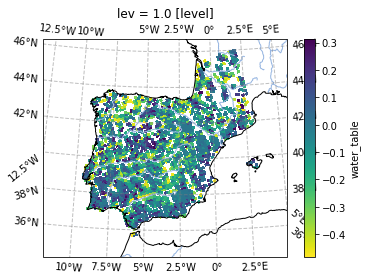

In [38]:
# Get color bar min and max
range_min = winter_summer_delta_10.min()
range_max = winter_summer_delta_10.max()

# Defined plot
fig = winter_summer_delta_10 \
    .plot(subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=-3, central_latitude=41),  
        facecolor="white"),
        transform=iberian_rotated_pole,
        cmap='viridis_r', vmin=range_min.values, vmax=range_max.values)

fig.axes.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
#fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

# plt.savefig('figures/water-table-winter-summer-delta-no-outliers-10.png', facecolor='white', bbox_inches='tight')

### Summary Statistics for All Data Variables

In [39]:
iberian.pressure \
    .sel() \
    .where(iberian.mask == 1) \
    .to_dataframe() \
    .describe()

mask      pressure
count  4.215750e+07  2.565038e+07
mean   6.084416e-01 -2.130568e+01
std    4.880988e-01  5.771542e+02
min    0.000000e+00 -2.659879e+04
25%    0.000000e+00 -2.093542e+00
50%    1.000000e+00  1.101610e-01
75%    1.000000e+00  4.439493e+00
max    1.000000e+00  5.403446e+01

In [40]:
iberian.saturation \
    .sel(time=date, lev=1.0) \
    .where(iberian.mask == 1) \
    .to_dataframe() \
    .describe()

lev         mask   saturation
count  7700.0  7700.000000  4685.000000
mean      1.0     0.608442     0.998384
std       0.0     0.488130     0.013000
min       1.0     0.000000     0.764481
25%       1.0     0.000000     1.000000
50%       1.0     1.000000     1.000000
75%       1.0     1.000000     1.000000
max       1.0     1.000000     1.000000

In [41]:
iberian.water_table \
    .sel(lev=1.0) \
    .where((iberian.mask == 1) &
          (iberian.water_table >= 0)) \
    .to_dataframe() \
    .describe()

mask   water_table
count  4.215750e+07  1.217687e+06
mean   6.084416e-01  1.169471e+01
std    4.880988e-01  1.425888e+01
min    0.000000e+00  8.122972e-07
25%    0.000000e+00  1.331896e+00
50%    1.000000e+00  5.029933e+00
75%    1.000000e+00  1.817990e+01
max    1.000000e+00  5.035423e+01

### Time Series Plots, Fixed Location

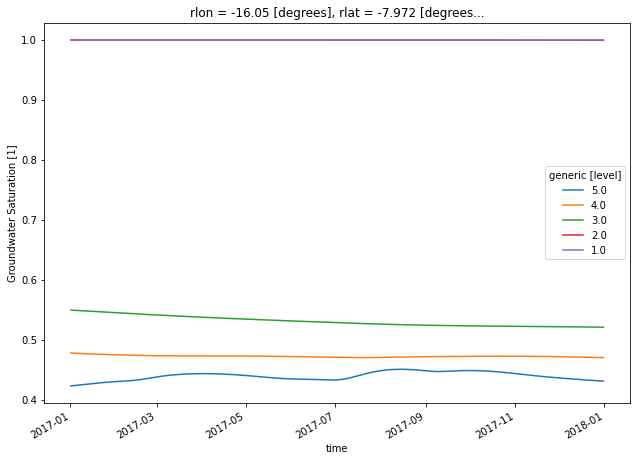

In [42]:
iberian.saturation.sel(rlat=latitude, rlon=longitude, lev=[5.0, 4.0, 3.0, 2.0, 1.0]).plot.line(x='time', size=7)

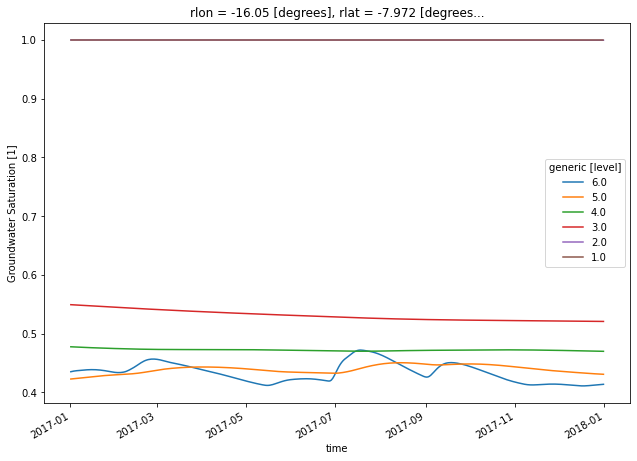

In [43]:
iberian.saturation.sel(rlat=-8, 
                       rlon=-16, 
                       lev=[6.0, 5.0, 4.0, 3.0, 2.0, 1.0], 
                       method='nearest').plot.line(x='time', size=7)
#plt.savefig('figures/saturation-lower-layers-time-series.png', facecolor='white', bbox_inches='tight')

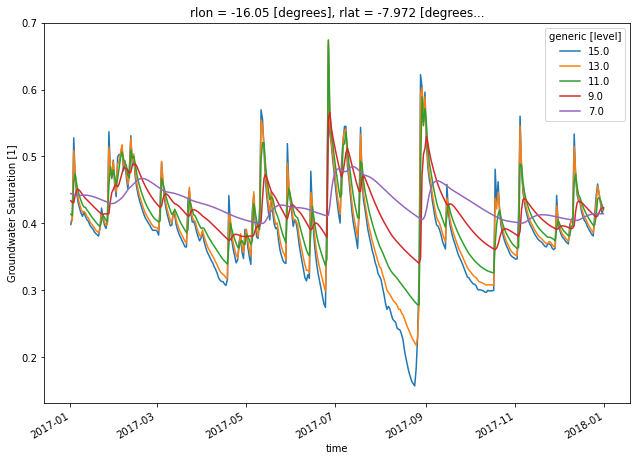

In [44]:
iberian.saturation.sel(rlat=-8, 
                       rlon=-16, 
                       lev=[15.0, 13.0, 11.0, 9.0, 7.0], 
                       method='nearest').plot.line(x='time', size=7)
#plt.savefig('figures/saturation-upper-layers-time-series.png', facecolor='white', bbox_inches='tight')

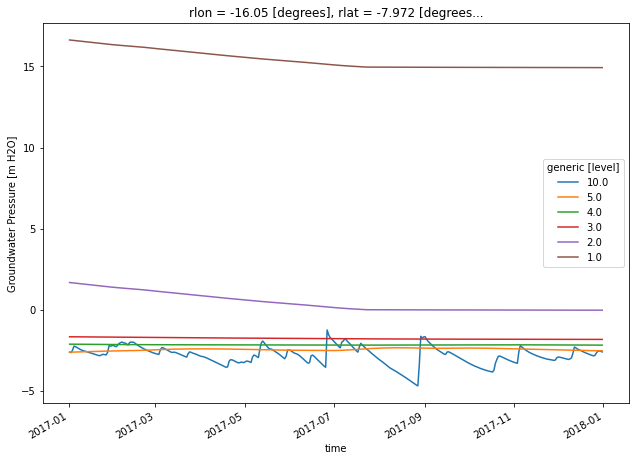

In [45]:
iberian.pressure.sel(rlon=longitude, rlat=latitude, lev=levels).plot.line(x='time', size=7)
#plt.savefig('figures/pressure-at-six-levels-fixed-day.png', facecolor='white', bbox_inches='tight')

### Line Plots and Histograms

In [46]:
pressure_time_series = iberian.pressure.sel(rlat=latitude, rlon=longitude, lev=level)
pressure_histogram = iberian.pressure.sel(rlat=latitude, rlon=longitude, lev=level)

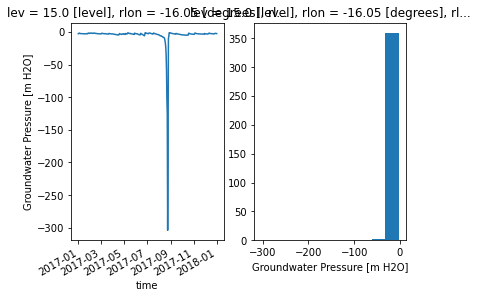

In [47]:
fig, axes = plt.subplots(ncols=2) 
axes
pressure_time_series.plot(ax=axes[0])
pressure_histogram.plot.hist(ax=axes[1])
plt.show()

### Time and Depth Series, Pressure and Saturation

#### Groundwater Saturation Per Level

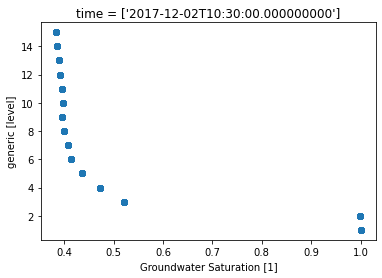

In [49]:
iberian.sel(time=date, rlat=latitude, rlon=longitude) \
    .where(iberian.mask == 1) \
    .plot.scatter(x='saturation', y='lev')

#### Groundwater Pressure Per Level

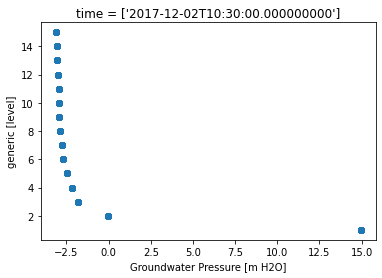

In [50]:
iberian.sel(time=date, rlat=latitude, rlon=longitude) \
    .where(iberian.mask == 1) \
    .plot.scatter(x='pressure', y='lev')

In [51]:
iberian.saturation.sel(time=date, rlon=longitude, rlat=latitude).values

array([[1.        , 0.99965664, 0.52166083, 0.47158147, 0.43597356,
        0.41383588, 0.40800808, 0.40012643, 0.39566187, 0.3965587 ,
        0.39499137, 0.39151223, 0.38829218, 0.38552261, 0.38354856]])

In [ ]:
  w